# **Desafío 1. Análisis exploratorio del dataset de precios de propiedades de Properatti**

# Ponderación de datos

Fuentes:
http://www.bibliotecacpa.org.ar/greenstone/collect/salagr/index/assoc/HASH0153.dir/doc.pdf
https://www.infobae.com/economia/2020/02/15/claves-para-entender-como-se-realiza-una-correcta-tasacion-a-la-hora-de-vender-una-vivienda/

Variables en orden decreciente de importancia para tasar:


*   Tipo de propiedad
*   Ubicación
*   Superficie



# Procesamiento de datos

## Entorno de implementación

In [ ]:
 !pip install geopandas


     |████████████████████████████████| 1.0 MB 29.4 MB/s 
     |████████████████████████████████| 15.4 MB 39 kB/s 
     |████████████████████████████████| 6.3 MB 43.2 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely 
import descartes 
import pyproj 
import re
from scipy.stats import iqr


In [ ]:
%matplotlib inline

In [ ]:
pd.options.display.float_format='{:,.2f}'.format

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
def custom_log10(x):
  return np.log10(x) if x != 0 else x

## Importación del dataset

In [ ]:
# Importamos el dataset y creamos el DataFrame

df = pd.read_csv('/content/drive/My Drive/properatti.csv')

## Exploración del dataset



In [ ]:
df.shape

In [ ]:
# Mostramos las columnas del df

df.columns

In [ ]:
# Mostramos registros aleatorios del df

df.sample(3)

In [ ]:
# Mostramos información de cada serie del df

df.info()

In [ ]:
# Evaluamos la densidad de datos de cada columna

df.isna().sum()*100/len(df)

In [ ]:
#Gráfico de la densidad de datos. Estructura de los valores faltantes.
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="PuRd")

In [ ]:
# sns.heatmap(df.isnull(), cbar=False)

In [ ]:
#Proporcion de NaN en las columnas
plt.figure(figsize=(10,6))
sns.displot(data=df.isna().melt(value_name="missing"), y="variable", hue="missing", multiple="fill", aspect=1.25)

# Eliminación de registros duplicados

In [ ]:
# Contabilizamos los registros del df

len(df)

121220

In [ ]:
# Eliminamos los registros duplicados

df = df.drop_duplicates()
len(df)

121220

In [ ]:
# Eliminamos los registros que cantengan el campo descripción y precio

df = df.drop_duplicates(subset=['description','price'])

In [ ]:
#Comprobamos los registros totales luego de la eliminación de duplicados

len(df)

111894

In [ ]:
# Dropeamos las series innecesarias y/o con alto nivel de NaN

df.drop(['Unnamed: 0', 'operation', 'country_name', 'floor', 'expenses', 'properati_url', 'image_thumbnail'], axis=1, inplace=True)

# Imputación de valores faltantes


## Expresiones regulares

Búsqueda de número de ambientes en descripción

In [ ]:
df.rooms[~df.rooms.isnull()]

13       1.00
14       1.00
16       4.00
17       3.00
19       3.00
         ... 
120203   2.00
120204   1.00
120205   5.00
120206   4.00
120207   1.00
Name: rooms, Length: 44273, dtype: float64

In [ ]:
# Porcentaje de datos faltantes en la columna
df.rooms.isnull().sum() * 100 / len(df)

60.43308845871986

In [ ]:
#cantidad de ambientes en descripción

patron = "(\d amb)"
regex = re.compile(patron)
description_series = df['description'].str.lower()
description_series = description_series.apply(lambda x: str(x))
resultado_ambientes = description_series.apply(lambda x: regex.findall(x))


In [ ]:
resultado_ambientes

0         [2 amb]
1              []
2         [2 amb]
3         [3 amb]
4              []
           ...   
121215         []
121216         []
121217         []
121218    [2 amb]
121219         []
Name: description, Length: 111894, dtype: object

In [ ]:
# Cantidad de datos
len([i for i in resultado_ambientes if i])

34848

In [ ]:
resultado_ambientes = resultado_ambientes.apply(lambda x: x[0] if len(x) != 0 else np.NaN )
resultado_ambientes = resultado_ambientes.str.split('amb')

In [ ]:
resultado_ambientes = resultado_ambientes.apply(lambda x: x[0] if x is not np.NaN else np.NaN )

In [ ]:
resultado_ambientes

0          2 
1         NaN
2          2 
3          3 
4         NaN
         ... 
121215    NaN
121216    NaN
121217    NaN
121218     2 
121219    NaN
Name: description, Length: 111894, dtype: object

In [ ]:
df['ambientes'] = resultado_ambientes

In [ ]:
df.ambientes

0          2 
1         NaN
2          2 
3          3 
4         NaN
         ... 
121215    NaN
121216    NaN
121217    NaN
121218     2 
121219    NaN
Name: ambientes, Length: 111894, dtype: object

In [ ]:
# Completamos los registros faltantes de rooms con los datos extraídos de la descripción
df['rooms'] = df['rooms'].fillna(df['ambientes'])

In [ ]:
df.rooms


0          2 
1         NaN
2          2 
3          3 
4         NaN
         ... 
121215    NaN
121216    NaN
121217    NaN
121218     2 
121219    NaN
Name: rooms, Length: 111894, dtype: object

In [ ]:
# Bajamos de 66% a 45% de datos faltantes
df.rooms.isnull().sum()*100 /len(df)

44.98632634457611

Búsqueda de precio en descripción

In [ ]:
patron_precio = "(dls|usd|\$)\s?(\d{5,8})|(\d{5,8})\s?(dls|usd|\$)"
regex_p = re.compile(patron_precio)
description_series = df['description'].str.lower()
description_series = description_series.apply(lambda x: str(x))
resultado_precio = description_series.apply(lambda x: regex_p.findall(x))

In [ ]:
resultado_precio.sample(15)

95737                     []
48444                     []
14919                     []
96195                     []
60476                     []
94251                     []
32491                     []
100509                    []
119130                    []
80430                     []
37174     [(usd, 50000, , )]
17480                     []
682                       []
4580                      []
97234                     []
Name: description, dtype: object

In [ ]:
[i for i in resultado_precio if i]

[[('usd', '300000', '', '')],
 [('usd', '50000', '', '')],
 [('usd', '72900', '', '')],
 [('usd', '150000', '', '')],
 [('usd', '120000', '', '')],
 [('usd', '125000', '', '')],
 [('usd', '165000', '', '')],
 [('usd', '135000', '', '')],
 [('usd', '95000', '', '')],
 [('usd', '80000', '', '')],
 [('usd', '430000', '', '')],
 [('usd', '95000', '', '')],
 [('usd', '181000', '', '')],
 [('usd', '143000', '', '')],
 [('usd', '120000', '', '')],
 [('usd', '160000', '', '')],
 [('usd', '460000', '', '')],
 [('usd', '140000', '', '')],
 [('usd', '78000', '', '')],
 [('usd', '130000', '', '')],
 [('usd', '150000', '', '')],
 [('usd', '360000', '', '')],
 [('usd', '465000', '', '')],
 [('usd', '385000', '', '')],
 [('usd', '72000', '', '')],
 [('usd', '120000', '', '')],
 [('usd', '200000', '', '')],
 [('usd', '150000', '', '')],
 [('usd', '450000', '', '')],
 [('usd', '75000', '', '')],
 [('usd', '40000', '', '')],
 [('usd', '99800', '', '')],
 [('usd', '375000', '', '')],
 [('usd', '54000', '

In [ ]:
precio_2 = resultado_precio.apply(lambda x: x[0][1] if ((len(x) != 0)) else np.NaN )

In [ ]:
precio_1 = resultado_precio.apply(lambda x: x[0][0] if ((len(x) != 0)) else np.NaN )
precio_1.iloc[16522]


nan

In [ ]:
df['precio_relleno'] = precio_2
df['precio_relleno_mon'] = precio_1
df.sample(3)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,ambientes,precio_relleno,precio_relleno_mon
44249,house,Martínez,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Bs.As. G.B.A. Zona Norte,"3,430,813.00",NaN,nan,nan,"1,800,000.00",USD,"31,760,100.00","1,800,000.00","1,784.00","1,200.00","1,008.97","1,500.00",NaN,"Importante residencia en exclusivo sector, en ...","Casa 1784m² con 3 Plantas en Colon 1300, San I...",NaN,NaN,NaN
75648,apartment,Capital Federal,|Argentina|Capital Federal|,Capital Federal,"3,433,955.00",NaN,nan,nan,"58,333.00",USD,"1,029,256.61","58,333.00",35.00,31.00,"1,666.66","1,881.71",NaN,EN POZO - MONOAMBIENTE CON BALCON ATERRAZADO E...,EN POZO - MONOAMBIENTE CON BALCON ATERRAZADO E...,NaN,NaN,NaN
22121,apartment,Mar del Plata,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,"3,430,863.00","-38.0035204,-57.5475146",-38.00,-57.55,"69,900.00",USD,"1,233,350.55","69,900.00",nan,34.00,nan,"2,055.88",2.00,"Dpto. 2 amb. cfte.Cómodo living comedor, pisos...",Dpto. 2 amb. cfte.,2,NaN,NaN


In [ ]:
len(df) - df.precio_relleno.isnull().sum()

4574

In [ ]:
df['precio'] = df['price_aprox_usd'].fillna(df['precio_relleno'])

In [ ]:
df.precio.isnull().sum() *100 / len(df)

14.292097878349152

In [ ]:
(~df.precio_relleno.isnull()).sum()

4574

Búsqueda de superficie en descripción

In [ ]:
#superficie en descripción
patron_sup = "((\d{1,3})\s?(m2)|(\d{1,3})\s?(metros))"
regex_sup = re.compile(patron_sup)
description_series = df['description'].str.lower()
description_series = description_series.apply(lambda x: str(x))
resultado_sup = description_series.apply(lambda x: regex_sup.findall(x))

In [ ]:
resultado_sup.head(20)

0                                                    []
1                                                    []
2                                                    []
3                                                    []
4                                                    []
5                                                    []
6     [(106 m2, 106, m2, , ), (78 m2, 78, m2, , ), (...
7                                                    []
8                                                    []
9                                                    []
10                      [(514 metros, , , 514, metros)]
11                                                   []
12                                                   []
13                        [(30 metros, , , 30, metros)]
14                        [(30 metros, , , 30, metros)]
15                                                   []
16                                                   []
17                                              

In [ ]:
df.description.iloc[6]

'MUY BUEN PH AL FRENTE CON ENTRADA INDEPENDIENTE - SIN EXPENSAS! TODO EN  PLANTA BAJA DOS DORMITORIOS (pisos de pinotea) - LIVING - COCINA COMEDOR - BAÑO - PATIO - GALPÓN Y LAVADERO EN EL PATIOEN MUY BUEN ESTADO - INMEJORABLE UBICACIÓN - A 1 CUADRA DE LA ESTACIÓN DE MUNRO -  CERCA DE MAS DE 6 LINEAS DE COLECTIVOS - A 2 CUADRAS DEL CENTRO UNIVERSITARIO. 106 m2 TOTALES: 78 m2 CUBIERTOS Y 28 m2 DESCUBIERTOSAPTO PROFESIONAL                                                 Aviso publicado por Pixel Inmobiliario (Servicio de Páginas Web para Inmobiliarias).'

In [ ]:
sup1 = resultado_sup.apply(lambda x: x[0][1] if ((len(x) != 0)) else np.NaN )

In [ ]:
(~sup1.isnull()).sum()

29924

## Localización


In [ ]:
df.place_name.value_counts()

Córdoba             7965
Rosario             6986
Mar del Plata       6434
Tigre               3076
Nordelta            2836
                    ... 
Villa Paranacito       1
Rancagua               1
La Serranita           1
Concepción             1
Villa Unión            1
Name: place_name, Length: 1058, dtype: int64

In [ ]:
#Separamos en distintos niveles la ubicacion geográfica
df.place_with_parent_names.value_counts().head(10)

|Argentina|Santa Fe|Rosario|                              6986
|Argentina|Buenos Aires Costa Atlántica|Mar del Plata|    6434
|Argentina|Córdoba|Córdoba|                               5588
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|Nordelta|       2836
|Argentina|Capital Federal|Belgrano|                      2699
|Argentina|Capital Federal|Palermo|                       2569
|Argentina|Córdoba|                                       2377
|Argentina|Bs.As. G.B.A. Zona Norte|Tigre|                2166
|Argentina|Capital Federal|Caballito|                     2085
|Argentina|Bs.As. G.B.A. Zona Norte|Pilar|                1803
Name: place_with_parent_names, dtype: int64

In [ ]:
split_geo = df.place_with_parent_names.str.split('|')

In [ ]:
split_geo

0               [, Argentina, Capital Federal, Mataderos, ]
1         [, Argentina, Bs.As. G.B.A. Zona Sur, La Plata, ]
2               [, Argentina, Capital Federal, Mataderos, ]
3                 [, Argentina, Capital Federal, Liniers, ]
4         [, Argentina, Buenos Aires Costa Atlántica, Ma...
                                ...                        
121215           [, Argentina, Capital Federal, Belgrano, ]
121216    [, Argentina, Bs.As. G.B.A. Zona Norte, San Is...
121217      [, Argentina, Capital Federal, Villa Urquiza, ]
121218    [, Argentina, Buenos Aires Costa Atlántica, Ma...
121219                     [, Argentina, Capital Federal, ]
Name: place_with_parent_names, Length: 111894, dtype: object

In [ ]:
df['ciudad_barrio'] = split_geo.apply(lambda x: x[3])
df['sub_loc'] = split_geo.apply(lambda x: x[-2])

In [ ]:
df.sub_loc.value_counts()

Córdoba              7965
Rosario              6986
Mar del Plata        6434
Tigre                3076
Nordelta             2836
                     ... 
Barrio San Benito       1
Laguna Larga            1
Cabildo                 1
Las Chacras             1
Villa Ventana           1
Name: sub_loc, Length: 1059, dtype: int64

In [ ]:
#agregamos el dataset de geonames.org para completar datos faltantes en latitud y longitud
data = pd.read_csv('/content/drive/My Drive/AR.txt', sep="\t", header=None)

In [ ]:
data.set_axis(['geonames_id', 'name', 'asciiname', 'alternatenames', 'latitude', 'longitude', 'feature_class', 'feature_code', 'country', 'code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code', 'population', 'dem', 'timezone', 'modification date'],axis=1, inplace=True)

In [ ]:
data.sample(2)

,geonames_id,name,asciiname,alternatenames,latitude,longitude,feature_class,feature_code,country,code,cc2,admin1_code,admin2_code,admin3_code,admin4_code,population,dem,timezone,modification date
26347,3849054,La Represa,La Represa,NaN,-25.40,-65.59,S,HSE,AR,NaN,17.00,"66,098.00",nan,nan,0,nan,1327,America/Argentina/Salta,2016-01-30
36601,3859334,Dique Nivelador,Dique Nivelador,NaN,-32.17,-64.38,P,PPL,AR,NaN,5.00,"14,007.00",nan,nan,0,nan,474,America/Argentina/Cordoba,2016-01-30


In [ ]:
# Eliminamos las columnas no relevantes para el análisis
data.drop(['asciiname', 'alternatenames', 'feature_class', 'feature_code', 'country', 'code', 'cc2', 'admin1_code', 'admin2_code', 'admin3_code', 'admin4_code', 'population', 'dem', 'timezone', 'modification date'],axis=1, inplace=True)

In [ ]:
#chequeamos que coincidan los registros de geoname entre los datasets
print(data[data['geonames_id'] == 3427455.0])
print(df[df['geonames_id'] == 3427455.0].sample(1))

     geonames_id              name  latitude  longitude
254      3427455  Villa del Parque    -34.60     -58.49
     property_type        place_name  ...     ciudad_barrio           sub_loc
8379            PH  Villa del Parque  ...  Villa del Parque  Villa del Parque

[1 rows x 25 columns]


In [ ]:
#Hacemos un merge de los dataset por "geonames_id"
df = df.merge(data, how='left', on= 'geonames_id')
df.sample(2)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,ambientes,precio_relleno,precio_relleno_mon,precio,ciudad_barrio,sub_loc,name,latitude,longitude
54240,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Santa Fe,"3,838,574.00","-32.948575,-60.644474",-32.95,-60.64,nan,NaN,nan,nan,nan,nan,nan,nan,3.00,Corredor Responsable: Rosana Gerosa - CI Mat. ...,Departamento 2 dormitorios Reciclado cochera v...,NaN,NaN,NaN,NaN,Rosario,Rosario,Rosario Department,-33.17,-60.75
29888,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Capital Federal,"3,430,234.00","-34.5735458,-58.417902",-34.57,-58.42,"375,000.00",USD,"6,616,687.50","375,000.00",83.00,75.00,"4,518.07","5,000.00",3.00,"Venta de Departamento 3 AMBIENTES en Palermo, ...",DEPARTAMENTO EN VENTA,3,NaN,NaN,"375,000.00",Palermo,Palermo,Palermo,-34.59,-58.43


In [ ]:
# Completalos la columan latitud y longitud a partir de los geonames
df['lat'] = df['lat'].fillna(df['latitude'])
df['lon'] = df['lon'].fillna(df['longitude'])


In [ ]:
#pasamos de 42% a 7% de NaN
print(df['lat'].isnull().sum()*100 / len(df))
print(df['lon'].isnull().sum()*100 / len(df))

7.130855988703594
7.130855988703594


In [ ]:
#eliminamos las columnas auxiliares
df.drop(['name', 'latitude', 'longitude'], axis =1, inplace=True)

In [ ]:
df.isna().sum()*100/len(df)

property_type                 0.00
place_name                    0.02
place_with_parent_names       0.00
state_name                    0.00
geonames_id                  15.71
lat-lon                      41.55
lat                           7.13
lon                           7.13
price                        14.31
currency                     14.31
price_aprox_local_currency   14.31
price_aprox_usd              14.31
surface_total_in_m2          33.34
surface_covered_in_m2        16.25
price_usd_per_m2             42.00
price_per_m2                 25.63
rooms                        44.99
description                   0.00
title                         0.00
ambientes                    68.86
precio_relleno               95.91
precio_relleno_mon           95.91
precio                       14.29
ciudad_barrio                 0.00
sub_loc                       0.00
dtype: float64

In [ ]:
# Buscamos las localidaes sin geoname, y les asignamos geoname y latitud y longitud.
c = df[df.lat.isnull()].sub_loc.unique()
c = pd.DataFrame(c)
c = c.set_axis(['name'], axis=1)
#asigno lat y long a cada uno
merge = c.merge(data, how= 'left', on= 'name')
merge

,name,geonames_id,latitude,longitude
0,Pilar,"3,429,980.00",-34.46,-58.91
1,Pilar,"3,480,748.00",-34.44,-58.91
2,Pilar,"3,841,149.00",-31.68,-63.88
3,Pilar,"3,841,150.00",-31.44,-61.26
4,Nordelta,"7,602,820.00",-34.41,-58.65
...,...,...,...,...
415,Mayu Sumaj,nan,nan,nan
416,Potrero de Garay,"7,733,379.00",-31.78,-64.55
417,Mi Granja,"12,035,914.00",-31.36,-64.00
418,El Nacional Club de Campo,nan,nan,nan


In [ ]:
merge = merge.rename(columns={'name' : 'sub_loc'})

In [ ]:
merge = merge.drop_duplicates(subset=['sub_loc'])

In [ ]:
merge.sub_loc.value_counts()

Mar de las Pampas       1
Bosque Peralta Ramos    1
Don Orione              1
El Remanso              1
Rumenco                 1
                       ..
Grand Bell              1
Costa Esmeralda         1
Presidente Perón        1
Pompeya                 1
Plaza Rocha             1
Name: sub_loc, Length: 224, dtype: int64

In [ ]:
# Unimos el dataframe auxiliar para asignar las ubicaciones faltantes a las localidades
df = df.merge(merge, how= 'left', on= 'sub_loc')
df.sample(2)

,property_type,place_name,place_with_parent_names,state_name,geonames_id_x,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,ambientes,precio_relleno,precio_relleno_mon,precio,ciudad_barrio,sub_loc,geonames_id_y,latitude,longitude
19670,apartment,Palermo,|Argentina|Capital Federal|Palermo|,Capital Federal,"3,430,234.00","-34.5855804,-58.4232627",-34.59,-58.42,"398,000.00",USD,"7,022,511.00","398,000.00",88.00,82.00,"4,522.73","4,853.66",3.00,Departamento de 3 ambientes en Palermo Soho. *...,DEPARTAMENTO DE 3 AMBIENTES CON BALCON,3,NaN,NaN,"398,000.00",Palermo,Palermo,nan,nan,nan
93829,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Santa Fe,"3,838,574.00",NaN,-33.17,-60.75,nan,NaN,nan,nan,29.00,26.00,nan,nan,NaN,Edificio en esquina ubicado en calle Urquiza y...,Departamento - Echesortu,NaN,NaN,NaN,NaN,Rosario,Rosario,nan,nan,nan


In [ ]:
df['lat'] = df['lat'].fillna(df['latitude'])
df['lon'] = df['lon'].fillna(df['longitude'])
df['geonames_id_x'] = df['geonames_id_x'].fillna(df['geonames_id_y'])

In [ ]:
df.shape

(111894, 28)

In [ ]:
#pasamos de 7% a 1,6% de NaN
print(df['lat'].isnull().sum()*100 / len(df))
print(df['lon'].isnull().sum()*100 / len(df))

1.7543389279139185
1.7543389279139185


In [ ]:
# Localidades que faltaron asignar
df[df['lat'].isnull()].ciudad_barrio.unique()

array(['San Isidro', 'Tigre', 'General San Martín', 'Berazategui',
       'Mar del Plata', 'Escobar', 'Ituzaingó', 'Lanús', 'La Matanza',
       'Palermo', 'Centro / Microcentro', 'Desamparados',
       'Costa Esmeralda', 'Pilar', 'José C Paz', 'La Plata',
       'Presidente Perón', 'Villa Ciudad Parque Los Reartes',
       'Tres de Febrero', 'Florencio Varela', 'Villa Santa Cruz del Lago',
       'Merlo', 'Lomas de Zamora', 'Campana', 'Brandsen', 'Moreno',
       'San Miguel', 'San Vicente', 'Malvinas Argentinas', 'Mar Chiquita',
       'General Rodríguez', 'Tribunales', '', 'Esteban Echeverría',
       'Mar Azul', 'Ezeiza', 'San Fernando', 'Catalinas',
       'Almirante Brown', 'Villa Parque Siquiman', 'La Serranita',
       'Mayu Sumaj'], dtype=object)

In [ ]:
#eliminamos las columnas auxiliares
df.drop(['geonames_id_y', 'latitude', 'longitude'], axis =1, inplace=True)

In [ ]:
#Chequeamos que las coordenadas sean razonables en contexto
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_argentina = world[world.name=='Argentina']
geo_limpio = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

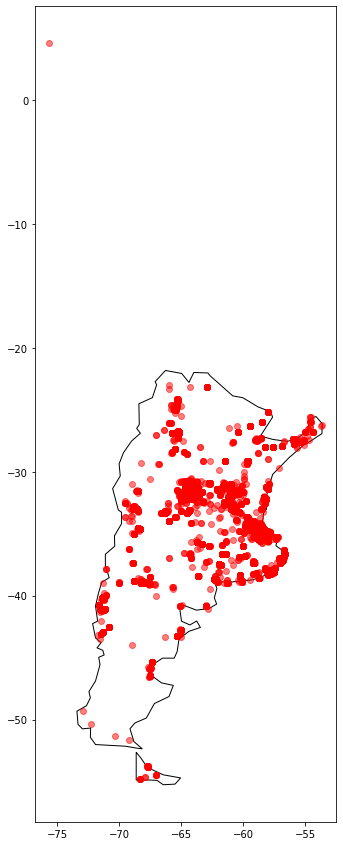

In [ ]:
ax = geo_argentina.plot(figsize=(10,15), color='white', edgecolor='black')
geo_limpio.plot(ax=ax, color='red', alpha= 0.5)

In [ ]:
df = df.rename(columns={'geonames_id_x' : 'geonames_id'})

In [ ]:
#resultado de la limpieza de las columnas realcionadas a la localización
df[['lat', 'lon','geometry', 'geonames_id']].isna().sum()*100/len(df)

lat           1.75
lon           1.75
geometry      0.00
geonames_id   5.25
dtype: float64

In [ ]:
#Agregamos columna de distancia al obelisco
punto_obelisco = (-58.381555,-34.605425)
from shapely.geometry import Point
punto_obelisco_p = Point(-58.381555,-34.605425)


In [ ]:
import geopy.distance
def distancia (row):
    lat_A, long_A = row['geometry'].x, row['geometry'].y
    try:
        return geopy.distance.geodesic((lat_A, long_A), punto_obelisco).meters
    except ValueError:
        return np.nan

df['distance_obelisco'] = geo_limpio.apply(distancia, axis=1)

In [ ]:
df.head(5)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,ambientes,precio_relleno,precio_relleno_mon,precio,ciudad_barrio,sub_loc,geometry,distance_obelisco
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"3,430,787.00","-34.6618237,-58.5088387",-34.66,-58.51,"62,000.00",USD,"1,093,959.00","62,000.00",55.00,40.00,"1,127.27","1,550.00",2,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB,2,NaN,NaN,"62,000.00",Mataderos,Mataderos,POINT (-58.50884 -34.66182),"14,555.08"
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,"3,432,039.00","-34.9038831,-57.9643295",-34.90,-57.96,"150,000.00",USD,"2,646,675.00","150,000.00",nan,nan,nan,nan,NaN,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...,NaN,NaN,NaN,"150,000.00",La Plata,La Plata,POINT (-57.96433 -34.90388),"49,679.03"
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,"3,430,787.00","-34.6522615,-58.5229825",-34.65,-58.52,"72,000.00",USD,"1,270,404.00","72,000.00",55.00,55.00,"1,309.09","1,309.09",2,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO,2,NaN,NaN,"72,000.00",Mataderos,Mataderos,POINT (-58.52298 -34.65226),"15,988.57"
3,PH,Liniers,|Argentina|Capital Federal|Liniers|,Capital Federal,"3,431,333.00","-34.6477969,-58.5164244",-34.65,-58.52,"95,000.00",USD,"1,676,227.50","95,000.00",nan,nan,nan,nan,3,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado,3,NaN,NaN,"95,000.00",Liniers,Liniers,POINT (-58.51642 -34.64780),"15,224.87"
4,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,"3,435,548.00","-38.0026256,-57.5494468",-38.00,-57.55,"64,000.00",USD,"1,129,248.00","64,000.00",35.00,35.00,"1,828.57","1,828.57",NaN,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...,NaN,NaN,NaN,"64,000.00",Mar del Plata,Centro,POINT (-57.54945 -38.00263),"221,376.15"


## Superficie

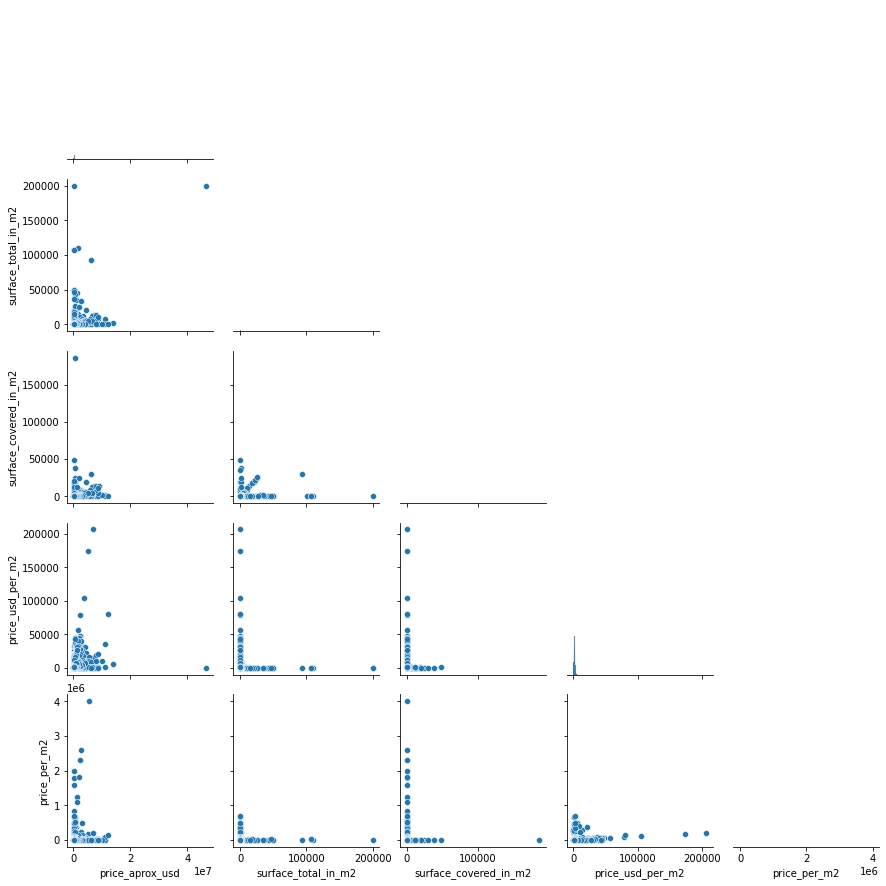

In [ ]:
sns.pairplot(df,vars=['price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2'],corner=True, dropna=True)


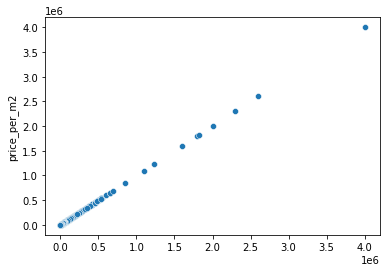

In [ ]:
sns.scatterplot( x=(df.price/df.surface_covered_in_m2), y=df.price_per_m2)

In [ ]:
# Creamos y agregamos al df la serie 'superficie_m2', y en la misma la completamos con el cociente de las columnas 'price' y 'price_per_m2'

df['superficie_m2'] = df['price'] / df['price_per_m2']


In [ ]:
# Contabilizamos los NaN de la columna 'superficie_m2' (en porcentaje)

df.superficie_m2.isna().sum()*100/len(df)

25.626932632670204

In [ ]:
# Sustituimos valores nulos de la nueva columna 'superficie_m2' por valores de la columna 'surface_total_in_m2'

df['surface_covered_in_m2'].fillna(df['surface_total_in_m2'], inplace=True)


In [ ]:
# Sustituimos valores nulos de la nueva columna 'superficie_m2' por valores de la columna 'surface_covered_in_m2'

df['surface_covered_in_m2'].fillna(df['superficie_m2'], inplace=True)


In [ ]:
# Pasamos de 16% (surface_total_in_m2 & surface_covered_in_m2) al 10% (surface_covered_in_m2) de NaN

In [ ]:
# Contabilizamos los NaN (en porcentaje).

df['surface_covered_in_m2'].isna().sum()*100/len(df)

10.463474359661824

In [ ]:
#Rellenamos lo que resta con los resultados del regex

df['sup1'] = sup1
df['surface_covered_in_m2'].fillna(df['sup1'], inplace=True)

In [ ]:
df.surface_covered_in_m2 = df.surface_covered_in_m2.apply(pd.to_numeric)

In [ ]:
df.surface_covered_in_m2.isna().sum()*100/len(df)

8.354335353102043

## Precio

In [ ]:
# Contabilizamos los tipos de registros de la serie 'currency'

df.currency.value_counts()

USD    83515
ARS    12367
PEN        2
UYU        1
Name: currency, dtype: int64

In [ ]:
# Quitamos monedas que no utilizaremos y que tienen registros no significativos en proporción al total

df.drop(df[df.currency=='PEN'].index, inplace=True)
df.drop(df[df.currency=='UYU'].index, inplace=True)

### Búsqueda de independencia entre columnas

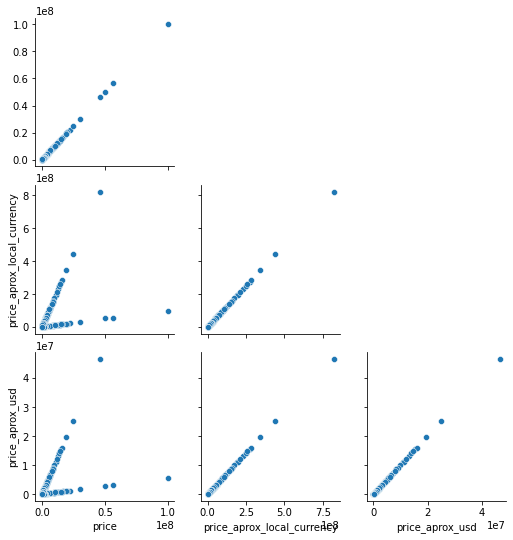

In [ ]:
sns.PairGrid(df,vars=['price', 'price_aprox_local_currency', 'price_aprox_usd'],corner=True, dropna=True).map(sns.scatterplot)

In [ ]:
# Calculamos coeficiente de correlación de Pearson entre dos Series

print('Correlación Pearson local currency and USD: ', df['price_aprox_local_currency'].corr(df['price_aprox_usd'], method='pearson'))

Correlación Pearson local currency and USD:  0.9999999999999996


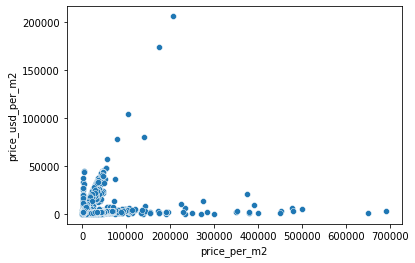

In [ ]:
# precio/m2 y precio/m2 en usd
sns.scatterplot( x=df.price_per_m2, y=df.price_usd_per_m2)

In [ ]:
# Calculamos coeficiente de correlación de Pearson entre dos Series

print('Correlación Pearson precio por metro and USD: ', df['price_per_m2'].corr(df['price_usd_per_m2'], method='pearson'))

Correlación Pearson precio por metro and USD:  0.1845481533567685


In [ ]:
# Comprobamos que la Serie 'price_per_m2' tiene precios en ambas monedas

table_price = pd.pivot_table(df,index=['currency'], values=['price_per_m2', 'price'], aggfunc=['count'])
table_price

count             
          price price_per_m2
currency                    
ARS       12367         9724
USD       83515        73495

##Imputación de precio

In [ ]:
# Calculamos la cotización del dólar de acuerdo a las Series 'price_aprox_local_currency' y 'price_aprox_usd'

cotizacion = df.price_aprox_local_currency / df.price_aprox_usd
cotizacion.median()

17.6445

In [ ]:
df[df.price_aprox_usd.isna()].sample(3)

,property_type,place_name,place_with_parent_names,state_name,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,description,title,ambientes,precio_relleno,precio_relleno_mon,precio,ciudad_barrio,sub_loc,geometry,distance_obelisco,superficie_m2,sup1
25278,house,Escobar,|Argentina|Bs.As. G.B.A. Zona Norte|Escobar|,Bs.As. G.B.A. Zona Norte,"3,434,130.00",NaN,-34.33,-58.75,nan,NaN,nan,nan,435.00,70.00,nan,nan,3.00,Casa Desarrollada en una Planta: Living- Comed...,"Casa en venta, Garin",NaN,NaN,NaN,NaN,Escobar,Escobar,POINT (-58.75000 -34.33333),"43,989.12",nan,NaN
2785,house,Ituzaingó,|Argentina|Bs.As. G.B.A. Zona Oeste|Ituzaingó|,Bs.As. G.B.A. Zona Oeste,"3,433,359.00","-34.65702438,-58.67539597",-34.66,-58.68,nan,NaN,nan,nan,515.00,36.00,nan,nan,1.00,"Loft conformado por un living comedor, cocina ...",U$D 120.000 - Casa en Venta -,NaN,NaN,NaN,NaN,Ituzaingó,Ituzaingó,POINT (-58.67540 -34.65702),"32,867.80",nan,NaN
97833,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|La ...,Bs.As. G.B.A. Zona Sur,"3,432,039.00",NaN,-35.00,-58.00,nan,NaN,nan,nan,63.00,50.00,nan,nan,NaN,DEPARTAMENTO VENTA - Calle 04 Entre 123 y 124 ...,Departamento - La Plata,NaN,NaN,NaN,NaN,La Plata,La Plata,POINT (-58.00000 -35.00000),"48,421.86",nan,80


In [ ]:
df_geo_m2 = df.groupby('geonames_id')['price_usd_per_m2'].agg(['count', 'median'])
df_geo_m2 = df_geo_m2.reset_index()

In [ ]:
# Calculamos el rango intercuartílico de la serie precio_m2, agrupado por la serie geonames_id
df_geo_m2['IQR'] = df_geo_m2['geonames_id'].map(df.groupby('geonames_id')['price_usd_per_m2'].agg(iqr, nan_policy='omit'))

/usr/local/lib/python3.7/dist-packages/numpy/lib/nanfunctions.py:1370: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


In [ ]:
df_geo_m2

,geonames_id,count,median,IQR
0,"3,427,208.00",4,123.96,86.12
1,"3,427,212.00",4,20.64,2.89
2,"3,427,326.00",89,"1,540.00",598.21
3,"3,427,354.00",9,"1,006.76",512.95
4,"3,427,366.00",6,750.16,298.31
...,...,...,...,...
720,"11,961,677.00",8,931.84,702.51
721,"12,035,914.00",0,nan,nan
722,"12,035,938.00",2,226.51,72.11
723,"12,035,960.00",2,137.92,43.90


In [ ]:
df = df.merge(df_geo_m2, how='left', on= 'geonames_id')

In [ ]:
df['precio_m2'] = df['price_usd_per_m2'].fillna(df['median'])

In [ ]:
df['precio_m2'].isnull().sum()*100/len(df)

2.7741283928108604

In [ ]:
#Imputacion del precio a partir del precio por m2 calculado por barrio

In [ ]:
df['surface_covered_in_m2'].fillna(0, inplace=True)
df['precio_m2'].fillna(0, inplace=True)

In [ ]:
# Convertimos los datos de las Series indicadas en tipo numéricos 

df[['surface_covered_in_m2', 'precio_m2']] = df[['surface_covered_in_m2', 'precio_m2']].apply(pd.to_numeric)

In [ ]:
df['precio_imp'] = df['surface_covered_in_m2'] * df['precio_m2']

In [ ]:
df.price_aprox_usd = df.price_aprox_usd.fillna(df.precio_imp)             

In [ ]:
print((df.price_aprox_usd==0).sum())
df['price_aprox_usd'] = np.where((df.price_aprox_usd == 0), np.NaN, df['price_aprox_usd'])

4657


In [ ]:
df['price_aprox_usd'].isna().sum()*100/len(df)

4.162086316146964

In [ ]:
df['segmento_precio_m2'] = pd.qcut(df.precio_m2, 3, labels=  ['bajo', 'medio', 'alto'])

In [ ]:
df[['lat', 'lon', 'geonames_id', 'surface_covered_in_m2','precio_m2','price_aprox_usd']].isna().sum()*100/len(df)

lat                     1.75
lon                     1.75
geonames_id             5.25
surface_covered_in_m2   0.00
precio_m2               0.00
price_aprox_usd         4.16
dtype: float64

# Gráficos y eliminación de outliers

Text(0.5, 0, 'log (Price USD)')

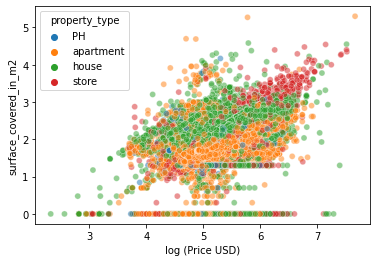

In [ ]:
# Quizas hacer un tasador aparte para store?

sns.scatterplot(x=((df.price_aprox_usd).apply(custom_log10)), y=(df.surface_covered_in_m2.apply(custom_log10)), hue=df.property_type, alpha=0.5)
plt.xlabel('log (Price USD)')

##Superficie

Text(0.5, 0, 'log (Price USD)')

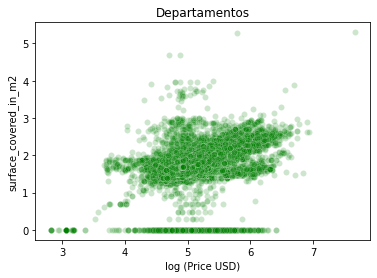

In [ ]:
sns.scatterplot(x=((df[(df.property_type == 'apartment')].price_aprox_usd).apply(custom_log10)), 
                y=(df[ (df.property_type == 'apartment')].surface_covered_in_m2.apply(custom_log10)), 
                color= 'green', alpha=0.2)
plt.title('Departamentos')
plt.xlabel('log (Price USD)')

In [ ]:
df.drop(df[(df.surface_covered_in_m2 >500) & (df.property_type == 'apartment')].index, inplace=True)


Text(0.5, 0, 'log (Price USD)')

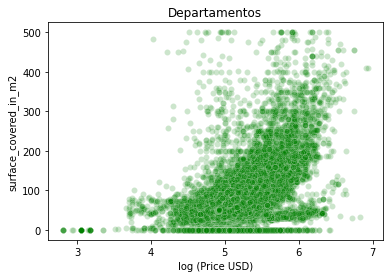

In [ ]:
sns.scatterplot(x=((df[(df.property_type == 'apartment')].price_aprox_usd).apply(custom_log10)),
                y=(df[ (df.property_type == 'apartment')].surface_covered_in_m2), 
                color= 'green', alpha=0.2)
plt.title('Departamentos')
plt.xlabel('log (Price USD)')

Text(0.5, 0, 'log (Price USD)')

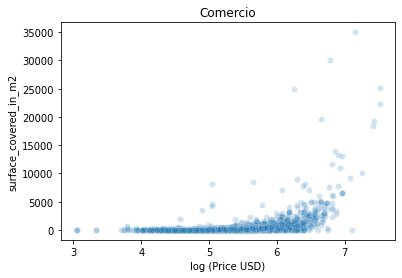

In [ ]:
sns.scatterplot(x=((df[(df.property_type == 'store')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'store')].surface_covered_in_m2),
                alpha=0.2)
plt.title('Comercio')
plt.xlabel('log (Price USD)')

In [ ]:
df.drop(df[(df.surface_covered_in_m2 > 5000) & (df.property_type == 'store') ].index, inplace=True)

Text(0.5, 0, 'log (Price USD)')

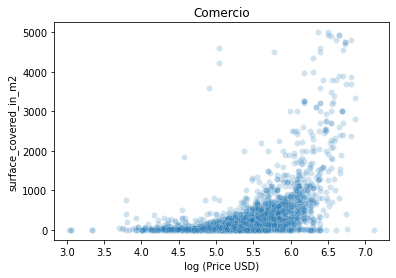

In [ ]:
sns.scatterplot(x=((df[(df.property_type == 'store')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'store')].surface_covered_in_m2),
                alpha=0.2)
plt.title('Comercio')
plt.xlabel('log (Price USD)')

Text(0.5, 0, 'log (Price USD)')

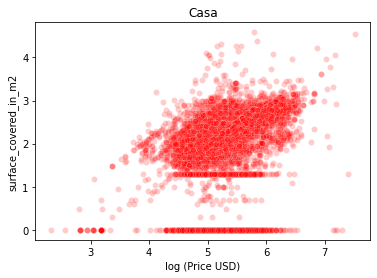

In [ ]:
sns.scatterplot(x=((df[(df.property_type == 'house')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'house')].surface_covered_in_m2.apply(custom_log10)),
                color='red', alpha=0.2)
plt.title('Casa')
plt.xlabel('log (Price USD)')

In [ ]:
df.drop(df[(df.surface_covered_in_m2 > 999) & (df.property_type == 'house') ].index, inplace=True)

Text(0.5, 0, 'log (Price USD)')

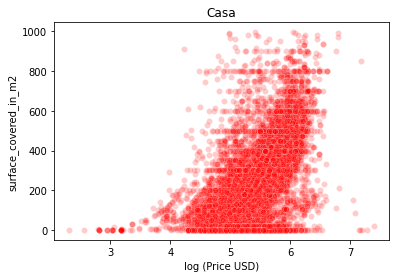

In [ ]:
sns.scatterplot(x=((df[(df.property_type == 'house')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'house')].surface_covered_in_m2),
                color='red', alpha=0.2)
plt.title('Casa')
plt.xlabel('log (Price USD)')

Text(0.5, 0, 'log (Superficie)')

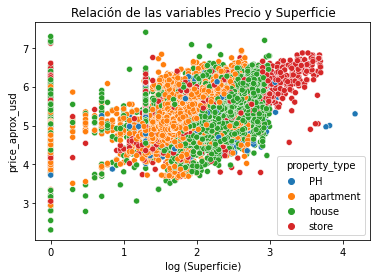

In [ ]:
#existen unidades grandes baratas --> probablemente outliers
sns.scatterplot(x=df.surface_covered_in_m2.apply(custom_log10), 
                y=df.price_aprox_usd.apply(custom_log10), 
                hue=df.property_type)
plt.title('Relación de las variables Precio y Superficie')
plt.xlabel('log (Superficie)')

In [ ]:
df.drop(df[df.surface_covered_in_m2 < 21].index, inplace=True)

##Precio

Text(0.5, 1.0, 'Distribución de precios en USD')

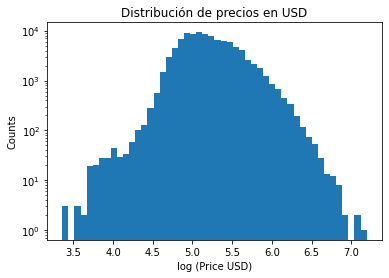

In [ ]:
#distribución de precios en usd
plt.hist(x=df.price_aprox_usd.apply(custom_log10), log=True, bins= 50)
plt.xlabel('log (Price USD)')
plt.ylabel('Counts')
plt.title('Distribución de precios en USD')


In [ ]:
#eliminamos precios de más de 5.10^6 y menores a 5000
df.drop(df[df.price_aprox_usd>5e6].index, inplace=True)
df.drop(df[df.price_aprox_usd<5000].index, inplace=True)

Text(0.5, 1.0, 'Distribución de precios en USD')

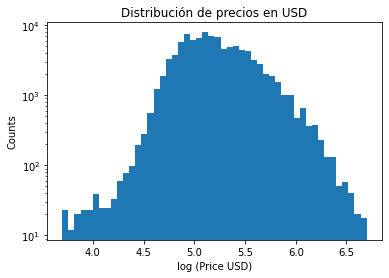

In [ ]:
plt.hist(x=df.price_aprox_usd.apply(custom_log10), log=True, bins= 50)
plt.xlabel('log (Price USD)')
plt.ylabel('Counts')
plt.title('Distribución de precios en USD')

##Precio_m2

Text(0.5, 1.0, 'Distribución de precios por m2')

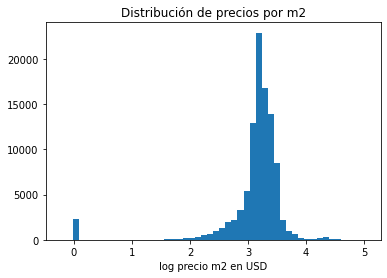

In [ ]:
#distribución de precio del m2. Varios outliers, posiblemente todos los de más de 6k/m2
plt.hist(x=(df.precio_m2.apply(custom_log10)), bins=50)
plt.xlabel("log precio m2 en USD")
plt.title('Distribución de precios por m2')

Text(0.5, 1.0, 'Propiedades con precios mayores 10k USD/m2')

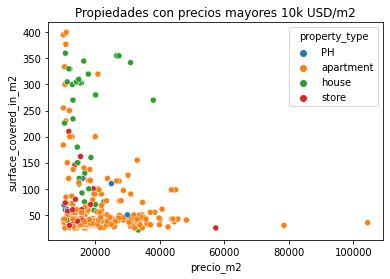

In [ ]:
#grafico de las unidades con más de 10k USD/m2
#muchas unidades de poca superficie, altos precios por m2. Algunas unidades outliers en superficie.
sns.scatterplot(x=(df[df.precio_m2>10000].precio_m2), y=(df[df.precio_m2  >10000].surface_covered_in_m2), hue=df.property_type)
plt.title('Propiedades con precios mayores 10k USD/m2')

In [ ]:
#no parecería que los outliers de precio/m2 sean unidades especiales. Deberiamos agregar por barrio
df[df.precio_m2>10000].property_type.value_counts()

apartment    730
house         52
store         18
PH             8
Name: property_type, dtype: int64

In [ ]:
#parecería ser un problema de un cero más en el input

(df[df.precio_m2>10000]).groupby('place_name')['precio_m2'].median()

place_name
Alejandro Roca                24,038.46
Almagro                       20,066.67
Balvanera                     13,066.67
Barracas                      29,562.50
Barrio Cerrado "La Delfina"   38,000.00
                                 ...   
Villa Luro                    32,885.55
Villa Luzuriaga               13,772.73
Villa Lynch                   11,333.33
Villa Santa Cruz del Lago     16,666.67
Villa Urquiza                 13,281.25
Name: precio_m2, Length: 66, dtype: float64

In [ ]:
#dividimos por 10 los que permanecen mayores a 15k USD/m2
df.loc[df.precio_m2>10000,'precio_m2' ] = df.loc[df.precio_m2>10000,'precio_m2']/10

Text(0.5, 1.0, 'Distribución de precios por m2')

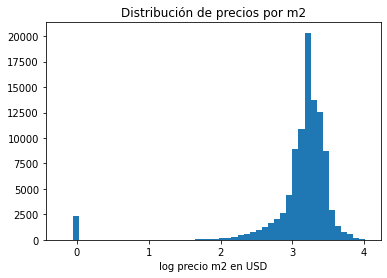

In [ ]:
#distribución de precio del m2 luego de descartar outliers
plt.hist(x=(df.precio_m2.apply(custom_log10)), bins=50)
plt.xlabel("log precio m2 en USD")
plt.title('Distribución de precios por m2')

In [ ]:
df.drop(df[df.precio_m2 < 5].index, inplace=True)

In [ ]:
#Buscamos outliers de geografia. No parece haber, ya lo eliminamos antes

In [ ]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
geo_argentina = world[world.name=='Argentina']
geo = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))

Text(0.5, 1.0, 'Localización de las propiedadesd el df')

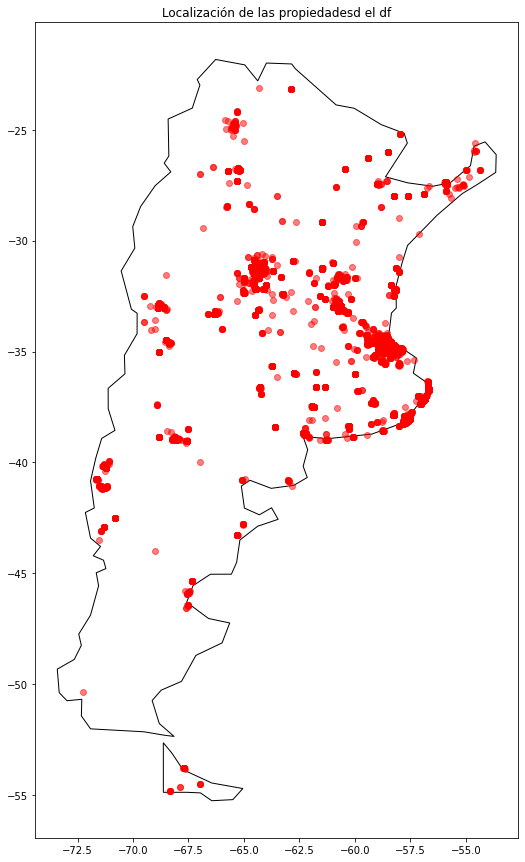

In [ ]:
ax = geo_argentina.plot(figsize=(10,15),color='white', edgecolor='black')
geo.plot(ax=ax, color='red', alpha= 0.5)
plt.title('Localización de las propiedadesd el df')
# plt.show()


# Dataset final


In [ ]:
df.columns

Index(['property_type', 'place_name', 'place_with_parent_names', 'state_name',
       'geonames_id', 'lat-lon', 'lat', 'lon', 'price', 'currency',
       'price_aprox_local_currency', 'price_aprox_usd', 'surface_total_in_m2',
       'surface_covered_in_m2', 'price_usd_per_m2', 'price_per_m2', 'rooms',
       'description', 'title', 'ambientes', 'precio_relleno',
       'precio_relleno_mon', 'precio', 'ciudad_barrio', 'sub_loc', 'geometry',
       'distance_obelisco', 'superficie_m2', 'sup1', 'count', 'median', 'IQR',
       'precio_m2', 'precio_imp', 'segmento_precio_m2'],
      dtype='object')

In [ ]:
#no dropear precio por metro 2
df.drop([ 'place_name', 'place_with_parent_names', 'state_name','geometry', 
         'lat-lon', 'price', 'currency','price_aprox_local_currency','superficie_m2', 
         'price_per_m2', 'rooms', 'description', 'title', 'ambientes', 
         'precio_relleno','precio_relleno_mon', 'surface_total_in_m2',
         'sup1', 'precio_imp','count','median', 'IQR', 'precio', 'geonames_id', 'price_usd_per_m2'], 
        axis=1, inplace=True)

In [ ]:
df.shape

(97136, 10)

In [ ]:
df.isnull().sum()*100/len(df)

property_type           0.00
lat                     1.36
lon                     1.36
price_aprox_usd         0.00
surface_covered_in_m2   0.00
ciudad_barrio           0.00
sub_loc                 0.00
distance_obelisco       1.36
precio_m2               0.00
segmento_precio_m2      0.00
dtype: float64

<Figure size 720x432 with 0 Axes>

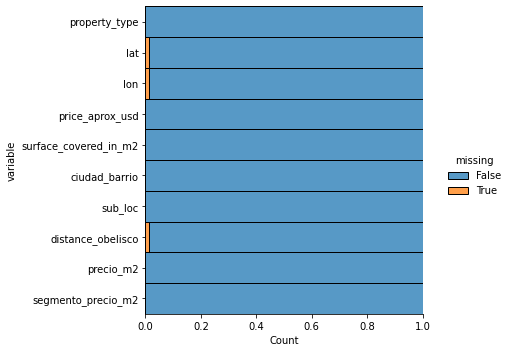

In [ ]:
plt.figure(figsize=(10,6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25)

In [ ]:
df.dropna(inplace=True)

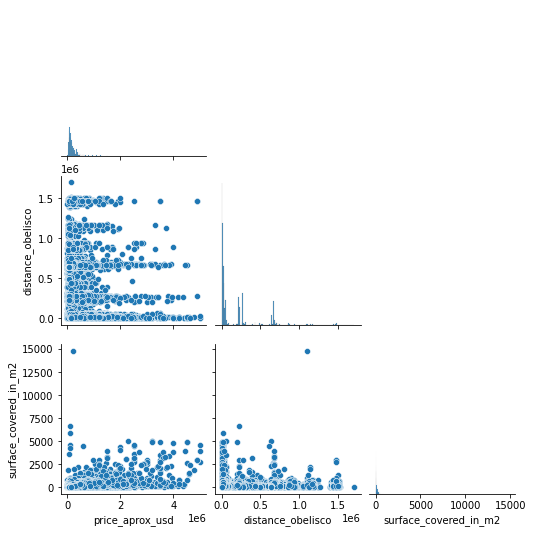

In [ ]:
sns.pairplot(df,vars=['price_aprox_usd', 'distance_obelisco', 'surface_covered_in_m2'],corner=True, dropna=True)

In [ ]:
# Cantidad de registros del df

df.shape

(95812, 10)

In [ ]:
# Diferencia entre registros iniciales y finales del df (en %)

len(df)*100/121220

79.039762415443

Text(0.5, 1.0, 'Comercial')

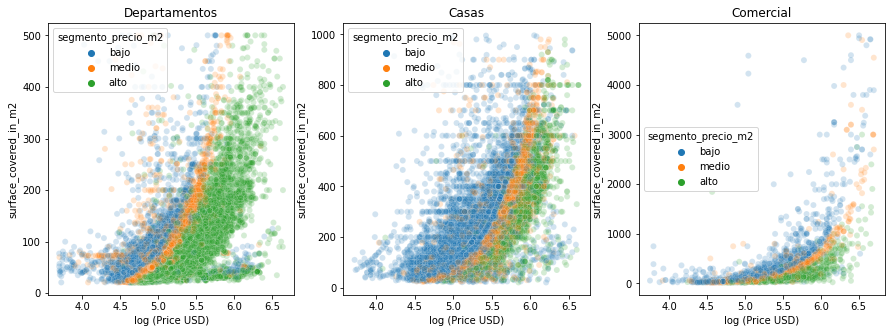

In [ ]:
fig, axs = plt.subplots(1,3, figsize=(15, 5))

sns.scatterplot(x=((df[(df.property_type == 'apartment')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'apartment')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[0], hue=df['segmento_precio_m2'])

axs[0].set_xlabel('log (Price USD)')
axs[0].set_title("Departamentos")

sns.scatterplot(x=((df[(df.property_type == 'house')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'house')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[1], hue=df['segmento_precio_m2'])

axs[1].set_xlabel('log (Price USD)')
axs[1].set_title("Casas")

sns.scatterplot(x=((df[(df.property_type == 'store')].price_aprox_usd).apply(custom_log10)), 
                y=(df[(df.property_type == 'store')].surface_covered_in_m2 ), 
                alpha=0.2, ax=axs[2], hue=df['segmento_precio_m2'])

axs[2].set_xlabel('log (Price USD)')
axs[2].set_title("Comercial")